In [ ]:
'''
This script runs a simple LSTM model on a single columns (XLocation or YLocation)
and predict k time steps in the future (t+1, t+2...t+k)
The testing activates the droupout in order to generate multiple different outputs
and then calculate the mean and standard deviation
https://fairyonice.github.io/Measure-the-uncertainty-in-deep-learning-models-using-dropout.html
'''


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pickle import dump, load
import sys
import keras
import keras.backend as K
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.models import load_model


Using TensorFlow backend.


In [10]:
class KerasDropoutPrediction(object):
    
    def __init__(self, model):
        self.f = K.function(
            [model.layers[0].input,
             K.learning_phase()],
            [model.layers[-1].output])
        
    def predict(self, x, n_iter=10):
        result = []
        for _ in range(n_iter):
            result.append(self.f([x, 1]))
        result = np.array(result).reshape(n_iter, len(x)).T
        
        #mean = result.mean(axis=0)
        #uncertainty = result.var(axis=0)
        #print("Mean:", mean, "Uncertainty:", uncertainty)
        #mean = np.mean(result)
        #std = np.std(result)
        
        return result
        
        


In [11]:
def plot_prediction(x, y_true, y_pred):
    """Plots the predictions.

    Arguments
    ---------
    x: Input sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_true: True output sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_pred: Predicted output sequence (input_sequence_length,
        dimension_of_signal)
    """
    label1 = "Seen (past) values"
    label2 = "True future values"
    label3 = "Predictions"
    
    plt.figure(figsize=(12, 3))
    plt.plot(range(len(x)),x, "o--b", label=label1)
    plt.plot(range(len(x), len(x) + len(y_true) ), y_true, "x--b", label=label2)
    plt.plot(range(len(x), len(x) + len(y_pred)),y_pred, "o--y", label=label3)
    
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()


In [58]:
def plot_prediction_ranges(x, y_true, y_pred, y_lower, y_upper, std, std_label):
    """Plots the predictions.

    Arguments
    ---------
    x: Input sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_true: True output sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_pred: Predicted output sequence (input_sequence_length,
        dimension_of_signal)
    """
    label1 = "Seen (past) values"
    label2 = "True future values"
    label3 = "Predictions"
    label4 = "Lower bound"
    label5 = "Upper bound"
    
    title = "Predictions v.s. true values ("+ str(std) \
            + " std. deviation, "+ std_label+"% )"
    
    plt.figure(figsize=(12, 3))
    plt.plot(range(len(x)),x, "o--b", label=label1)
    plt.plot(range(len(x), len(x) + len(y_true) ), y_true, "x--b", label=label2)
    plt.plot(range(len(x), len(x) + len(y_pred)),y_pred, "o--y", label=label3)
    
    plt.plot(range(len(x), len(x) + len(y_pred)),y_lower, "+--r", label=label4)
    plt.plot(range(len(x), len(x) + len(y_pred)),y_upper, "*--r", label=label5)
    
    plt.legend(loc='best')
    plt.title(title)
    plt.show()    


In [13]:
def size_per_targets(data):
    #print("Total: ", data.shape[0])
    sizes = data.groupby(['id', 'file_id']).size()
    #print(sizes)
    #print(type(sizes))
    #print("Total:",sum(list(sizes)))

    return list(sizes)


In [14]:
def generate_input_data(data, sizes, train_len, target_seq):
    targets = len(sizes)
    start = 0
    sequences = []
    X = []
    y = []
    
    for i, size in enumerate(sizes):
        print("Chunk", i+1)
        end = start + size
        print("Size of block %d, Range: %d-%d" % (size, start, end))
        temp_df = data.iloc[start:end]
        
        values = temp_df.iloc[:,-target_seq].values
        for i in range(train_len, len(values)):
            seq = values[i-train_len:i]
            
            sequences.append(seq)
                   
        # update start
        start = start + size
    
    sequences = np.array(sequences)    
    print("[INFO] Sequences generated:", len(sequences))
    
    X = sequences[:,:-target_seq]
    y = sequences[:,-target_seq]

    return X, y



# MAIN   


## Load the data

In [102]:
filename = 'data/AllData.csv'
data = pd.read_csv(filename)
print(data.shape)
print(list(data.columns))


(500050, 18)
['id', 'file_id', 'Pn', 'Pe', 'h', 'Va', 'Phi', 'Theta', 'Chi', 'Psi', 'Vg', 'Azimuth', 'Elevation', 'XPixel', 'YPixel', 'ZValue', 'XLocation', 'YLocation']


## Generate the input data


#### Defining Parameters


In [103]:
column_of_interest = 'XLocation'
input_seq = 10
target_seq = 1      # 
predict_k = 3       # predict k time steps in the future
train_len = input_seq + target_seq
target = 0     # 0 = AllTargets

test_percentage = 0.2
rand_test = True

dropout = .4
batch_size = 64
neurons = 64
epochs = 5

k_test_instances = 50      # number of randomly chosen instances to test
p_instances_to_plot = 3
n_results = 100         # Number of predictions for the dropout

model_filename = 'models/model_lstm_'+column_of_interest+"_"+str(input_seq)+"_timesteps_dropout.h5"
scaler_filename = 'models/model_lstm_'+column_of_interest+"_"+str(input_seq)+"_timesteps_dropout"


## Generate input data


In [104]:
# -1 is All data, else is the target id

if target != 0:
    input_data = data[data['id'] == target]
else:
    input_data = data

# Take only the column of interest
input_data = input_data[['id', 'file_id', column_of_interest]]
columns = input_data.columns

# We need to generate the sequences based on the id and file_id
sizes = size_per_targets(input_data)
X, y = generate_input_data(input_data, sizes, train_len, target_seq)


Chunk 1
Size of block 10001, Range: 0-10001
Chunk 2
Size of block 10001, Range: 10001-20002
Chunk 3
Size of block 10001, Range: 20002-30003
Chunk 4
Size of block 10001, Range: 30003-40004
Chunk 5
Size of block 10001, Range: 40004-50005
Chunk 6
Size of block 10001, Range: 50005-60006
Chunk 7
Size of block 10001, Range: 60006-70007
Chunk 8
Size of block 10001, Range: 70007-80008
Chunk 9
Size of block 10001, Range: 80008-90009
Chunk 10
Size of block 10001, Range: 90009-100010
Chunk 11
Size of block 10001, Range: 100010-110011
Chunk 12
Size of block 10001, Range: 110011-120012
Chunk 13
Size of block 10001, Range: 120012-130013
Chunk 14
Size of block 10001, Range: 130013-140014
Chunk 15
Size of block 10001, Range: 140014-150015
Chunk 16
Size of block 10001, Range: 150015-160016
Chunk 17
Size of block 10001, Range: 160016-170017
Chunk 18
Size of block 10001, Range: 170017-180018
Chunk 19
Size of block 10001, Range: 180018-190019
Chunk 20
Size of block 10001, Range: 190019-200020
Chunk 21
Siz

### Getting train, test data

In [105]:

# If we select the train and test randomly
if rand_test:
    print("Randomly picking train, test dataset")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percentage, 
                                                        shuffle=False, random_state=42)
# Else, select the last % part as testing
else:
    print("Train, test split based on percentage")
    test_size = int(X.shape[0] * test_percentage)
    train_size = int(X.shape[0] - test_size)
    print("Train size:", train_size)
    X_train = X[:train_size, :]
    X_test = X[train_size:, :]
    
    y_train = y[:train_size]
    y_test = y[train_size:]    

print("X Train size=", X_train.shape[0])
print("X Test size=",X_test.shape[0])
print("y Train size=", y_train.shape[0])
print("y Test size=",y_test.shape[0])


Randomly picking train, test dataset
X Train size= 399600
X Test size= 99900
y Train size= 399600
y Test size= 99900


### Scale the Input Data


In [106]:
# fit the values between 0 and 1
scaler_object = MinMaxScaler()

scaler_object.fit(X_train)

scaled_X_train =  scaler_object.transform(X_train)
scaled_X_test =  scaler_object.transform(X_test)

train_X = scaled_X_train.reshape((scaled_X_train.shape[0], 1, scaled_X_train.shape[1]))
test_X = scaled_X_test.reshape((scaled_X_test.shape[0], 1, scaled_X_test.shape[1]))


#print(train_X.shape, y_train.shape, test_X.shape, y_test.shape)

train_X = train_X.reshape((scaled_X_train.shape[0], scaled_X_train.shape[1], 1))

test_X = test_X.reshape((scaled_X_test.shape[0], scaled_X_test.shape[1], 1))
print("(Instances,Sequence,Features)")
print(train_X.shape, y_train.shape, test_X.shape, y_test.shape)



(Instances,Sequence,Features)
(399600, 10, 1) (399600,) (99900, 10, 1) (99900,)


## Create the LSTM model


In [20]:
### If it is already saved then do not run it again, it takes time
# design network
model = Sequential()
model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(neurons))
model.add(Dropout(dropout))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network
history = model.fit(train_X, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(test_X, y_test), verbose=2, shuffle=False)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 64)            16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________

KeyboardInterrupt: 

### Plot the loss

In [38]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

print(history.history.keys())


NameError: name 'history' is not defined

### Save the model and scaler


In [ ]:
print(model_filename)
model.save(model_filename)
print(scaler_filename)
dump(scaler_object, open(scaler_filename, 'wb'))


### Load the model


In [107]:
model = load_model(model_filename)
scaler_object = load(open(scaler_filename, 'rb'))


## Make predictions with dropout
As it will take a lot of time do the prediction for all the test set
I pick a random number of test instances



In [108]:

indices = np.random.choice(range(test_X.shape[0]), replace=False, size=k_test_instances)
print(indices)

 

[ 2317 27761 40374 17487 28357 67837 41231 16921 76346 92934  7289 28154
 33396 33929 77095 61387 36133 62937 60419 11730  7692 56711 36462 18771
 87701 25778 52370 40373 41142 75027 41880 88534 69928 84815 58212 53213
 23871 85717 55999  6097 11070 63165 93776 18918 18527 67930 66881  8890
 69509 57150]


In [109]:

kdp = KerasDropoutPrediction(model)

y_true = []
y_hat = []
y_hat_std = []
for i, index in enumerate(indices):
    x_test = test_X[index]
    y_true.append(y_test[index])
    result = kdp.predict([x_test], 1000)
    #print(result.flatten())
    #print(result.shape)
    yhat_mean = np.mean(result)
    yhat_std = np.std(result)
    print(i+1, '\t', index, '\tMean:', yhat_mean, 'Std:', yhat_std, 'y',y_test[index])
    y_hat.append(yhat_mean)
    y_hat_std.append(yhat_std)

print(y_true)
print(len(y_true))
print(y_hat)
print(len(y_hat))
print(y_hat_std)
print(len(y_hat_std))


1 	Mean: 231.46628 Std: 12.544475 y 233.75
2 	Mean: 257.86954 Std: 15.755453 y 260.7
3 	Mean: 167.28947 Std: 6.457458 y 171.2
4 	Mean: 172.46854 Std: 6.72563 y 175.05
5 	Mean: 228.70079 Std: 12.214785 y 230.9
6 	Mean: 145.4418 Std: 4.0385375 y 149.9
7 	Mean: 212.32954 Std: 10.799389 y 214.05
8 	Mean: 202.28647 Std: 9.488181 y 203.35
9 	Mean: 263.62265 Std: 16.087658 y 271.1
10 	Mean: 197.06685 Std: 8.833075 y 198.4
11 	Mean: 81.10926 Std: 5.637208 y 85.2
12 	Mean: 237.54675 Std: 13.406973 y 241.05
13 	Mean: 306.8865 Std: 20.473112 y 321.8
14 	Mean: 331.87625 Std: 22.57197 y 348.45
15 	Mean: 293.97443 Std: 19.511032 y 308.55
16 	Mean: 220.24434 Std: 11.690272 y 222.85
17 	Mean: 253.81938 Std: 14.555339 y 258.45
18 	Mean: 198.75641 Std: 8.943022 y 199.75
19 	Mean: 171.17244 Std: 6.6665926 y 174.45
20 	Mean: 234.29266 Std: 12.894705 y 237.5
21 	Mean: 51.212753 Std: 9.512874 y 65.05
22 	Mean: 431.789 Std: 32.432487 y 450.05
23 	Mean: 268.411 Std: 16.044226 y 274.9
24 	Mean: 105.16002 Std: 

### Calculating Prediction Ranges (lower and upper bounds)


In [129]:
def get_ranges(y_hat, y_hat_std, num_stds=1):
    y_hat_lowers = []
    y_hat_uppers = []

    for i in range(len(y_hat)):
        point = y_hat[i]
        std = y_hat_std[i]
        lower = point - (num_stds * std)
        upper = point + (num_stds * std)
        
        y_hat_lowers.append(lower)
        y_hat_uppers.append(upper)
        
    
    return y_hat_uppers, y_hat_lowers


With std deviation

In [111]:
std_dev = 3
std_dev_labels = {1:'0.68', 2:'0.95', 3:'0.997'}


In [112]:
print("Results with %d standad deviation" % std_dev)
y_hat_uppers, y_hat_lowers = get_ranges(y_hat, y_hat_std, std_dev)
print("Upper:\t", y_hat_uppers)
print("Mean:\t",y_hat)
print("Truth:\t", y_true)
print("Lower:\t",y_hat_lowers)



Results with 3 standad deviation
Upper:	 [269.0997018814087, 305.13589668273926, 186.66184854507446, 192.6454257965088, 265.3451442718506, 157.55741548538208, 244.72771072387695, 230.7510118484497, 311.88562393188477, 223.56607246398926, 98.02088451385498, 277.767671585083, 368.30584144592285, 399.59216117858887, 352.5075225830078, 255.3151559829712, 297.4853982925415, 225.58547401428223, 191.1722173690796, 272.9767780303955, 79.75137424468994, 529.0864639282227, 316.54368782043457, 111.11066949367523, 288.382098197937, 393.1313228607178, 313.46935272216797, 185.69950914382935, 237.22899341583252, 338.73101806640625, 284.3170909881592, 250.90038967132568, 157.62490892410278, 289.3428907394409, 526.2001495361328, 357.9281406402588, 288.7472448348999, 288.3208951950073, 531.8272514343262, 151.23407101631165, 231.89583015441895, 210.47528982162476, 166.6896858215332, 106.126944065094, 124.921071767807, 157.51450657844543, 157.39248418807983, 65.02244281768799, 157.51265287399292, 529.5562

## Evaluate the model
from random samples


In [113]:
# make a prediction
#print("test_X shape", test_X.shape)
#yhat = model.predict(test_X)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_hat))
print('Test RMSE: %.3f' % rmse)
mae = np.sqrt(mean_absolute_error(y_true, y_hat))
print('Test MAE: %.3f' % mae)


Test RMSE: 8.822
Test MAE: 2.564


## Comparing results

In [75]:
# Picked k random test instances
#t_X = test_X.reshape(test_X.shape[0], test_X.shape[1])
##t_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])


In [114]:
print(indices)

plot_indices = np.random.choice(list(indices), replace=False, size=p_instances_to_plot)
print(plot_indices)

plot_indices_idx = []
for p in plot_indices:
    idx = list(indices).index(p)
    plot_indices_idx.append(idx)
    
print(plot_indices_idx)


[ 2317 27761 40374 17487 28357 67837 41231 16921 76346 92934  7289 28154
 33396 33929 77095 61387 36133 62937 60419 11730  7692 56711 36462 18771
 87701 25778 52370 40373 41142 75027 41880 88534 69928 84815 58212 53213
 23871 85717 55999  6097 11070 63165 93776 18918 18527 67930 66881  8890
 69509 57150]
[58212 17487 40373]
[34, 3, 27]


### Plot some tests

58212
17487
40373


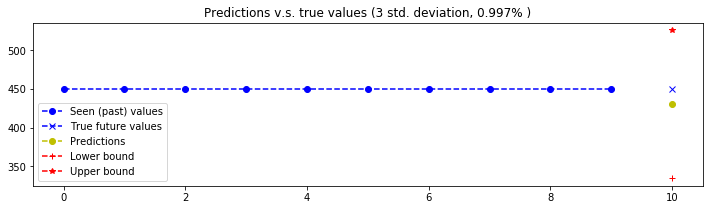

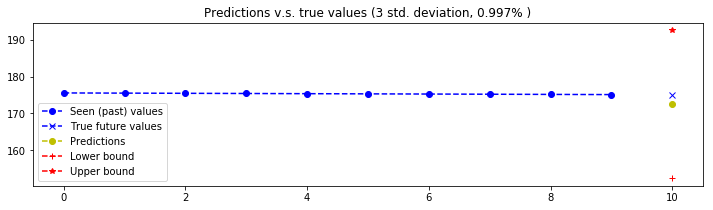

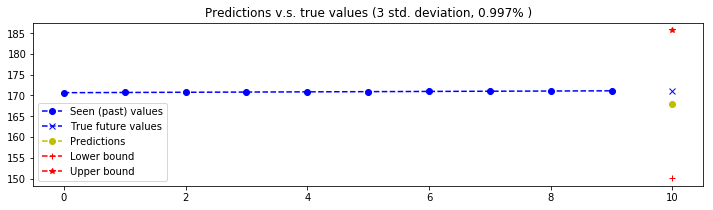

In [115]:
#indices = np.random.choice(range(t_X.shape[0]), replace=False, size=3)
for i, index in enumerate(plot_indices):
    print(index)
    x_test = test_X[index]
    x_test = x_test.reshape(x_test.shape[1], x_test.shape[0])
    test_X_rescaled = scaler_object.inverse_transform(x_test)
    y_idx = list(indices).index(index)
    
    plot_prediction_ranges(test_X_rescaled[0], [y_test[index]], 
                           [y_hat[y_idx]], [y_hat_lowers[y_idx]],[y_hat_uppers[y_idx]],
                           std_dev, std_dev_labels[std_dev])



## Predicting k steps in the future


In [116]:
all_predictions = []
all_deviations = []
for index in plot_indices:
    print("~"*50)
    print("~"*50)
    print("Predictions for index:", index)
    x_test = np.asarray([test_X[index]])    
    input = x_test
    print("input shape", input.shape)
    
    predictions = []
    std_deviations = []
    for i in range(predict_k):
        print("Pred ", i+1)    
        print("Input shape:", input.shape)
        window = input.reshape(x_test.shape[0], x_test.shape[1])
        ##print("Window")
        ##print(window)
        ##print("window shape",window.shape)
        
        # This will convert the values to Location values
        window_rescaled = scaler_object.inverse_transform(window)
        print("Window rescaled")
        print(window_rescaled)
        print("window rescaled shape:",window_rescaled.shape)
        
        result = kdp.predict(input, 1000)
        #print(result.flatten())
        #print(result.shape)
        yhat_mean = np.mean(result)
        yhat_std = np.std(result)
        
        #yhat = model.predict(input)
        yhat = yhat_mean
        print("Pred ", i+1, ":", yhat)
        
        #predictions.append(yhat[0][0])    
        predictions.append(yhat)
        print('yhat', yhat)
        ##print(type(yhat))
        ##print(type(window_rescaled))

        std_deviations.append(yhat_std)
        
        input = np.append(window_rescaled[:,1:], yhat)
        print("New window:", input)
        print("New window shape", input.shape)
 
        input = input.reshape(1, input.shape[0], window.shape[0])
        ##print("New new input shape:", input.shape)
        ##print(input)
        # This will convert the location values to scaled values
        
        input = input.reshape(1, input.shape[1])
        input = scaler_object.transform(input)
        ##print("New scaled input")
        ##print(input)
        ##print("New scaled input shape", input.shape)
        
        input = input.reshape(1, input.shape[1], window.shape[0])
        ##print("input shape",input.shape)
        print("#" * 50)
        
    print(predictions)
    print(std_deviations)
    
    all_predictions.append(predictions)
    all_deviations.append(std_deviations)
print()
print(all_predictions)
print(all_deviations)
      

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Predictions for index: 58212
input shape (1, 10, 1)
Pred  1
Input shape: (1, 10, 1)
Window rescaled
[[450.05 450.05 450.05 450.05 450.05 450.05 450.05 450.05 450.05 450.05]]
window rescaled shape: (1, 10)
Pred  1 : 430.36127
yhat 430.36127
New window: [450.05       450.05       450.05       450.05       450.05
 450.05       450.05       450.05       450.05       430.36126709]
New window shape (10,)
##################################################
Pred  2
Input shape: (1, 10, 1)
Window rescaled
[[450.05       450.05       450.05       450.05       450.05
  450.05       450.05       450.05       450.05       430.36126709]]
window rescaled shape: (1, 10)
Pred  2 : 431.28857
yhat 431.28857
New window: [450.05       450.05       450.05       450.05       450.05
 450.05       450.05       450.05       430.36126709 431.28857422]
New window shape (10,)
#######################################

### Get the ranges


In [143]:
all_uppers = []
all_lowers = []
all_means = []

print("Results with %d standard deviations" % std_dev)
for i, index in enumerate(plot_indices):
    print(i)
    y_hats = all_predictions[i]
    std_devs = all_deviations[i]
    #print(y_hats)
    #print(std_devs)
    y_uppers = []
    y_lowers = []
    y_means = []
    for j in range(len(y_hats)):
        yhat = [y_hats[j]]
        ystd = [std_devs[j]]
        #print('yhat:',yhat)
        #print('ystd:',ystd)
        
        y_hat_uppers, y_hat_lowers = get_ranges(yhat, ystd, std_dev)
        
        print("Upper:\t", y_hat_uppers[0])
        print("Mean:\t",yhat[0])
        print("Truth:\t", y_test[index])
        print("Lower:\t",y_hat_lowers[0])
        print()
        y_uppers.append(y_hat_uppers[0])
        y_lowers.append(y_hat_lowers[0])
        y_means.append(yhat[0])
    print()
    
    all_uppers.append(y_uppers)
    all_lowers.append(y_lowers)
    all_means.append(y_means)


Results with 3 standard deviations
0
Upper:	 534.956169128418
Mean:	 430.36127
Truth:	 450.05
Lower:	 325.76636505126953

Upper:	 533.9304618835449
Mean:	 431.28857
Truth:	 450.05
Lower:	 328.6466865539551

Upper:	 530.3808441162109
Mean:	 430.39047
Truth:	 450.05
Lower:	 330.4001007080078


1
Upper:	 192.63925075531006
Mean:	 172.17592
Truth:	 175.05
Lower:	 151.71258640289307

Upper:	 193.2585530281067
Mean:	 172.87677
Truth:	 175.05
Lower:	 152.4949870109558

Upper:	 192.28834581375122
Mean:	 172.33281
Truth:	 175.05
Lower:	 152.37727308273315


2
Upper:	 186.5986247062683
Mean:	 167.721
Truth:	 171.15
Lower:	 148.84336137771606

Upper:	 186.1955246925354
Mean:	 167.745
Truth:	 171.15
Lower:	 149.2944655418396

Upper:	 184.9589385986328
Mean:	 167.2465
Truth:	 171.15
Lower:	 149.53407287597656




In [144]:
print(all_uppers)
print(all_means)
print(all_lowers)


[[534.956169128418, 533.9304618835449, 530.3808441162109], [192.63925075531006, 193.2585530281067, 192.28834581375122], [186.5986247062683, 186.1955246925354, 184.9589385986328]]
[[430.36127, 431.28857, 430.39047], [172.17592, 172.87677, 172.33281], [167.721, 167.745, 167.2465]]
[[325.76636505126953, 328.6466865539551, 330.4001007080078], [151.71258640289307, 152.4949870109558, 152.37727308273315], [148.84336137771606, 149.2944655418396, 149.53407287597656]]


58212
17487
40373


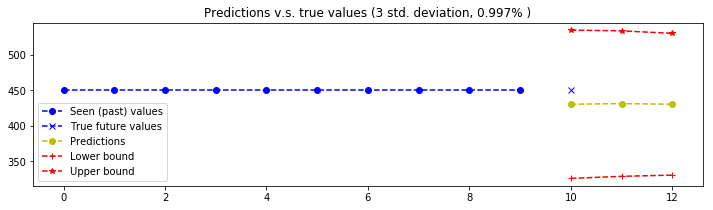

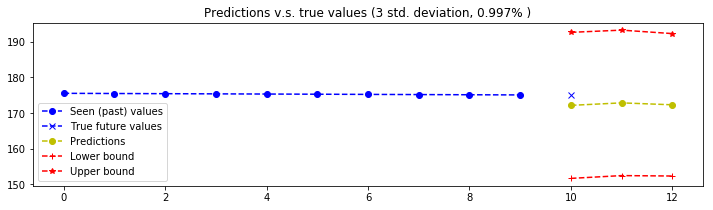

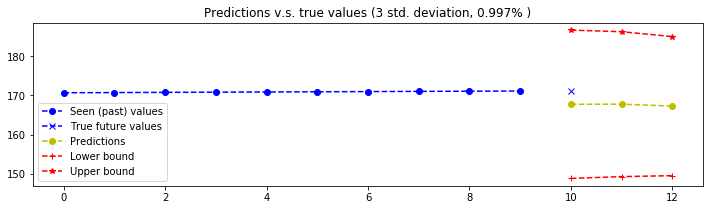

In [148]:
for i, index in enumerate(plot_indices):
    print(index)
    x_test = test_X[index]
    x_test = x_test.reshape(x_test.shape[1], x_test.shape[0])
    test_X_rescaled = scaler_object.inverse_transform(x_test)
    y_idx = list(indices).index(index)
    
    plot_prediction_ranges(test_X_rescaled[0], [y_test[index]], 
                           all_means[i], all_lowers[i],
                           all_uppers[i],
                           std_dev, std_dev_labels[std_dev])



        

## Plot future predictions


In [ ]:
for i,index in enumerate(indices):
    x_test = test_X[index]
    x_test = x_test.reshape(x_test.shape[1], x_test.shape[0])
    test_X_rescaled = scaler_object.inverse_transform(x_test)
    #plot_prediction
    print("Initial X:",test_X_rescaled[0])
    print("True t+1:",[y_test[index]])
    print("k predictions",all_predictions[i])
    plot_prediction(test_X_rescaled[0], [y_test[index]], all_predictions[i])
    
    